![logo](./img/LogoLine_horizon_C3S.png)

# Tutorial on total precipitation using CARRA data

### About

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse total precipitation. The tutorial comprises the following steps:

1. Search, download and view data for a given day in June 2023 for CARRA and ERA5
2. Calculate total precipitation accumulations
3. Visualize the total precipitation over Greenland
4. Visualise the total sum of precipitation over Greenland



<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/carlos9917/carra-training-c3s/main?labpath=CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/carlos9917/carra-training-c3s/blob/main/CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/carlos9917/carra-training-c3s/blob/main/CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

![logo](./img/climatology_banner.png)

In [1]:
# Import the libraries needed for this notebook
# Library to download data from the CDS
import cdsapi
c = cdsapi.Client()

# Libraries for working with grib-files and multidimensional arrays
from cdo import *
cdo   = Cdo()
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

# Libraries to handle dates and system related
import datetime
import os
import warnings
warnings.filterwarnings('ignore') #turn off some warnings


In [2]:
### Helper function for fetching CARRA total precipitation from the CDS.

def fetching(year, mon, day, time, leadtime, DATADIR):
    '''
    Function for fetching CARRA total precipitation from the CDS.
    The function won't fetch the data if the file exists already.
    Needed parameters for the function: year, mon, day, time, leadtime, DATADIR
    The fetched data will be saved in DATADIR.
    '''
    if isinstance(day, list):
        fday = day[0]
    else:
        fday = day

    target_file = os.path.join(DATADIR,'Precipitation_fc_'+str(year)+"{:02d}".format(mon)+"{:02d}".format(fday)+"{:02d}".format(time)+'.grb'
                              )   
    if not os.path.isfile(target_file):
        c.retrieve(
        'reanalysis-carra-single-levels',
        {
            'format': 'grib',
            'domain': 'west_domain',
            'level_type': 'surface_or_atmosphere',
            'variable': 'total_precipitation',
            'product_type': 'forecast',
            'time': time,
            'leadtime_hour': leadtime,
            'year': year,
            'month': mon,
            'day': day,
        },
        target_file)
    else:
        print(f"{target_file} already downloaded")


### Applaying the function defined above, CARRA data will be fetched for the dates specified below. Note that the specific dates have been hardcoded for this specific case study. The data will be stored in the specified catalogue.

In [3]:
print ("Fetching the data now...")
temp_dir = "CARRA"
if not os.path.isdir(temp_dir):
    os.makedirs(temp_dir)

DATADIR = temp_dir

# In order to compute the accumulated precipitation for a complete month the following forecasts need to be fetched from the CDS.
fetching(2023, 5, 31, 12, [12, 18], DATADIR)
days = [x for x in range(1,31)]
fetching(2023, 6, days, 12, [6, 12, 18], DATADIR)
fetching(2023, 6, days, 0, [6, 18], DATADIR)


Fetching the data now...
CARRA/Precipitation_fc_2023053112.grb already downloaded
CARRA/Precipitation_fc_2023060112.grb already downloaded
CARRA/Precipitation_fc_2023060100.grb already downloaded


## Computation of daily means 
### The computation of the daily precipitation is following the guideline provide in the [CARRA user documentation](https://confluence.ecmwf.int/pages/viewpage.action?pageId=338485814). Here, daily sum are computed from 0 UTC - 0 UTC following example 2 in the documentation. We use the [CDO package](https://code.mpimet.mpg.de/projects/cdo) to perform the computations.
### Note again that the file names have been hardcoded for this specific case study.
### Please note that the values for precipitation can turn negative if you take the difference between different forecasts lengths. That's a consequence of the grib encoding and details are explained [here](https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ). These very small negative values can be ignored or they could be set to zero.

In [4]:
# Calculate the daily sums with help of CDO 
indata = "CARRA/"
outdata = "Daily_means/"
if not os.path.isdir(outdata):
    os.makedirs(outdata)

# Separate the different forecasts lenghts from the fetched files.
cdo.splithour(input=indata+'Precipitation_fc_2023053112.grb', output=outdata+'Precipitation_fc_20230531_')
cdo.splithour(input=indata+'Precipitation_fc_2023060100.grb', output=outdata+'Precipitation_fc_2023060100_')
cdo.splithour(input=indata+'Precipitation_fc_2023060112.grb', output=outdata+'Precipitation_fc_2023060112_')

# Subtract the forecasts valid at 0 UTC from the forescasts valid at 6 UTC to receive the accumulated precipitation for the period 0 - 6 UTC.
file1 = outdata+'Precipitation_fc_2023060112_06.grb '
file2 = outdata+'Precipitation_fc_2023060112_00.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_00-06UTC.grb')

# Subtract the forecasts valid at 6 UTC from the forescasts valid at 18 UTC to receive the accumulated precipitation for the period 6 - 18 UTC.
file1 = outdata+'Precipitation_fc_2023060100_18.grb '
file2 = outdata+'Precipitation_fc_2023060100_06.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_06-18UTC.grb')

# Subtract the forecasts valid at 18 UTC from the forescasts valid at 24 UTC to receive the accumulated precipitation for the period 18 - 24 UTC.
# Here, we modify even the date for the 24 UTC field since this field has the date for the next day.
file1 = " -shifttime,-1minute "+outdata+'Precipitation_fc_2023060112_00.grb '
file2 = outdata+'Precipitation_fc_2023060112_18.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_18-24UTC.grb')

# Special treatment of the period 0 - 6 UTC on the first day of the month. This is needed since the forecast is initialized in the previous month.
file1 = outdata+'Precipitation_fc_20230531_06.grb '
file2 = outdata+'Precipitation_fc_20230531_00.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_20230601_00-06UTC.grb')

# Finally, all computed precipitation fields are merged into one file and the daily sum is computed.
inputstring=" -selmon,6 -mergetime "+outdata+'Precipitation_20230601_00-06UTC.grb '+outdata+'Precipitation_202306_06-18UTC.grb '+outdata+'Precipitation_202306_18-24UTC.grb '+outdata+'Precipitation_202306_00-06UTC.grb '
cdo.daysum(input=inputstring, output=outdata+'Precipitation_202306_daysum.grb')


'Daily_means/Precipitation_202306_daysum.grb'

## Now, download ERA5 precipitation and compute daily sums

In [5]:
# Specify the area you want to download.
area_greenland = [85,-110,50,30]

# Save ERA5 data in a separate directory.
DATADIR= "ERA5/"
if not os.path.isdir(DATADIR):
    os.makedirs(DATADIR)
target_file = os.path.join(DATADIR,'ERA5_tp_202306_hourly.grb')

# ERA5 comes with accumulated precipitation for every hour. These hourly values will be downloaded now.
if not os.path.isfile(target_file):
    c.retrieve(
        'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'variable': 'total_precipitation',
        'year': '2023',
        'month': '06',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': area_greenland,
    },
    target_file)
else:
    print(f"{target_file} already downloaded")

# Compute the daily sums with CDO. The result is stored in the specified file.
cdo.daysum(input=" -mulc,1000 "+target_file, output=DATADIR+'ERA5_tp_202306_daysum.grb')

ERA5/ERA5_tp_202306_hourly.grb already downloaded


'ERA5/ERA5_tp_202306_daysum.grb'

### All data is prepared and we start inspecting the data by producing a simple plot of the CARRA precipitation.

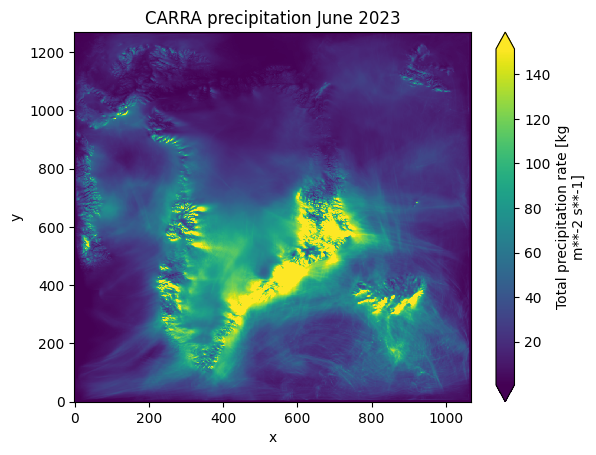

In [6]:
# Open the CARRA data with XArray
DATADIR= "CARRA/"
fCARRA = f'Daily_means/Precipitation_202306_daysum.grb'
CARRA = xr.open_dataset(fCARRA)

# Compute monthly sum. The result is kept in memory only, not saved to disc.
CARRA_sum = CARRA.sum(dim="step", keep_attrs=True)

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
CARRA_sum = CARRA_sum.assign_coords(longitude=(((CARRA_sum.longitude + 180) % 360) - 180))

# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_sum.variables)
CARRA_da = CARRA_sum['tprate']

# Produce a simple plot
CARRA_da.plot(robust=True)
plt.title("CARRA precipitation June 2023")
# In case you would like to save the figure, that's the command:
#plt.savefig(f'{DATADIR}/Figures/CARRA_west_202306_simple.png')
plt.show()


### Now, we plot ERA5 precipitation with a somewhat more advanced plotting routine.

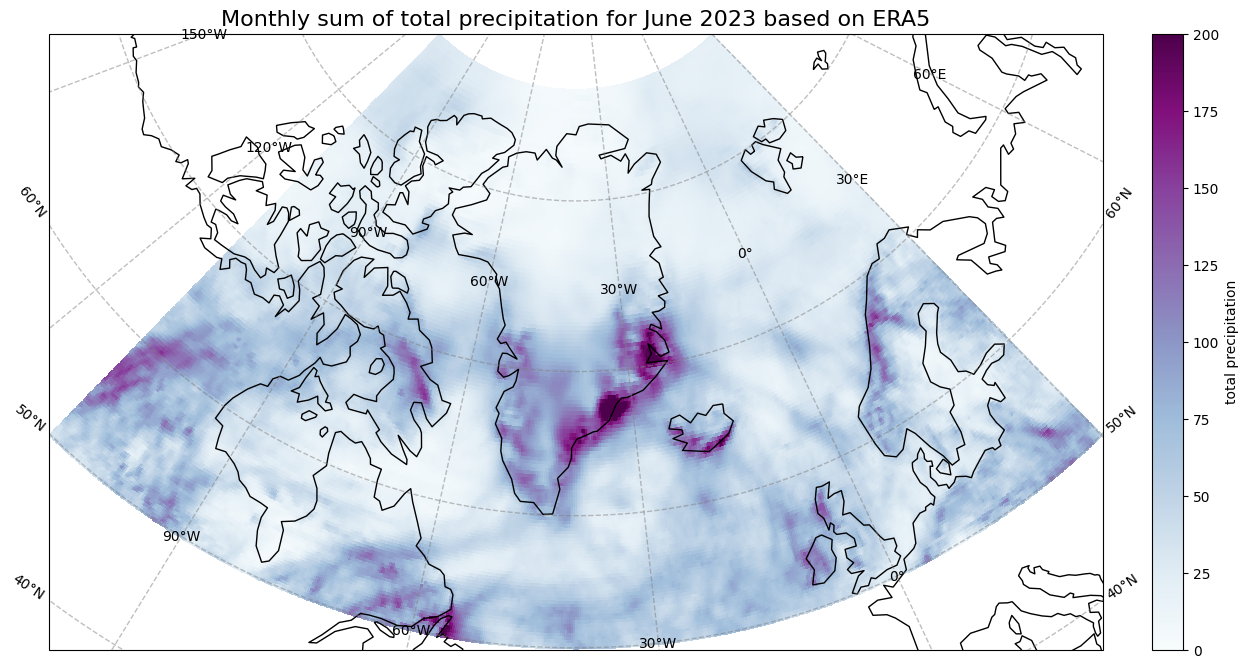

In [7]:
# Plot ERA5
DATADIR = 'ERA5'
fERA5 = f'{DATADIR}/ERA5_tp_202306_daysum.grb'

### Open Dataset
ERA5 = xr.open_dataset(fERA5)

# Compute monthly mean
ERA5_sum = ERA5.sum(dim="time", keep_attrs=True)

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
ERA5_sum = ERA5_sum.assign_coords(longitude=(((ERA5_sum.longitude + 180) % 360) - 180))

# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_mean.variables)
ERA5_da = ERA5_sum['tp']

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_da.longitude, ERA5_da.latitude, ERA5_da, transform = ccrs.PlateCarree(), cmap='BuPu', vmin=0, vmax=200) 

# Enhance the figure by setting a title, drawing coastlines and longitudes/latitudes
ax.set_title('Monthly sum of total precipitation for June 2023 based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('total precipitation') 

# Show the figure or save it with the commented command.
plt.show()
#fig.savefig(f'{DATADIR}/Figures/CARRA_west_202306_monthly_mean_precipitation.png')

### In order to enable a more detailed comparison between CARRA and ERA5, we interpolate ERA5 onto the CARRA grid.

In [8]:
# Interpolate ERA5 onto the CARRA grid, again with the help of CDO
cdo.remapbil('./Daily_means/Precipitation_202306_daysum.grb', input='./ERA5/ERA5_tp_202306_daysum.grb', output='./ERA5/ERA5_tp_202306_daysum_CARRA_grid.grb')

# Read and prepare the interpolated data for plotting
fERA5 = f'ERA5/ERA5_tp_202306_daysum_CARRA_grid.grb'

### Open Dataset
ERA5 = xr.open_dataset(fERA5)

# Compute monthly mean
ERA5_sum = ERA5.sum(dim="time", keep_attrs=True)

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
ERA5_sum = ERA5_sum.assign_coords(longitude=(((ERA5_sum.longitude + 180) % 360) - 180))

# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_mean.variables)
ERA5_da = ERA5_sum['tp']

### Plot the difference between ERA5 and CARRA

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_da.longitude, ERA5_da.latitude, ERA5_da-CARRA_da, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-100, vmax=100) 
#im = plt.pcolormesh(CARRA_da.longitude, CARRA_da.latitude, CARRA_da, transform = ccrs.PlateCarree(), cmap='RdBu_r', norm=colors.LogNorm(vmin=0, vmax=6))

# Enhance the figure by setting a title, drawing coastlines and longitudes/latitudes
ax.set_title('Difference between ERA5 and CARRA for monthly accumulated precipitation in June 2023', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('total precipitation') 

# Save the figure
plt.show()